In [2]:
%matplotlib inline
import os
import time
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import pickle
import scipy
import cv2
from PIL import ImageOps
import pydot

In [3]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Input, concatenate
from keras.utils import to_categorical
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.models import load_model
import tensorflow as tf
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

/home/shahidikram0701/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/shahidikram0701/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
img_width, img_height = 200, 200
nb_train_samples = 4125
nb_validation_samples = 466 
batch_size = 8
epochs = 10

data_size = 6000

In [5]:
def load_dataset():
    path_to_file = "../Selfie-dataset/selfie_dataset.txt"
    df = pd.read_csv(path_to_file, sep=" ", header=None, encoding='utf-8')
    print(type(df))
    df.columns = ["image_name","popularity_score","partial_faces","is_female","baby","child","teenager","youth","middle_age","senior","white","black","asian","oval_face","round_face","heart_face","smiling","mouth_open","frowning","wearing_glasses","wearing_sunglasses","wearing_lipstick","tongue_out","duck_face","black_hair","blond_hair","brown_hair","red_hair","curly_hair","straight_hair","braid_hair","showing_cellphone","using_earphone","using_mirror","braces","wearing_hat","harsh_lighting","dim_lighting"]
#     df = df[["image_name", "popularity_score", "is_female", "baby", "child", "teenager", "youth", "middle_age","senior"]]
   

    return df


In [6]:
data = load_dataset()
print(data.shape)
data = data.sample(data_size)
data.head()

<class 'pandas.core.frame.DataFrame'>
(46836, 38)


,image_name,popularity_score,partial_faces,is_female,baby,child,teenager,youth,middle_age,senior,...,curly_hair,straight_hair,braid_hair,showing_cellphone,using_earphone,using_mirror,braces,wearing_hat,harsh_lighting,dim_lighting
46667,c5ed20f4a54811e3821012c3dbb2818a_6,3.874,1,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,1,-1,-1,-1,-1
38671,1941173_634418179965484_1091453797_a,4.985,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
14073,10246042_1571231286436098_429425591_a,4.836,1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
31241,1515859_728077243916503_2121347214_a,4.272,-1,1,-1,-1,-1,1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
26868,1171728_1410123469255420_747181102_a,3.209,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [7]:
data.shape

(6000, 38)

In [8]:
# remove female = 0
data = data.drop(data[data.is_female == 0].index)

In [9]:
columns = list(data.columns)

In [10]:
for col in range(2, len(columns)):
    data=data.replace({columns[col]: {-1: 0}})
data.head(7)

,image_name,popularity_score,partial_faces,is_female,baby,child,teenager,youth,middle_age,senior,...,curly_hair,straight_hair,braid_hair,showing_cellphone,using_earphone,using_mirror,braces,wearing_hat,harsh_lighting,dim_lighting
38671,1941173_634418179965484_1091453797_a,4.985,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14073,10246042_1571231286436098_429425591_a,4.836,1,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
31241,1515859_728077243916503_2121347214_a,4.272,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
26868,1171728_1410123469255420_747181102_a,3.209,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9090,10175153_692438580814402_683500289_a,3.343,1,1,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,0,0
42773,926725_392317737574968_1922547161_a,4.163,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
6889,10013134_439841382817687_1118356711_a,4.560,0,1,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0


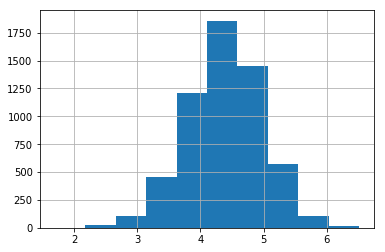

In [11]:
data["popularity_score"].hist()

In [12]:
pd.qcut(data['popularity_score'], 3).value_counts()

(4.138, 4.642]                 1932
(1.6960000000000002, 4.138]    1931
(4.642, 6.511]                 1926
Name: popularity_score, dtype: int64

In [13]:
def threshold(x):
    if(x < 4.138):
        return 0
    elif(x > 4.642):
        return 2
    return 1
data = data.assign(label=pd.Series(list(map(lambda x: threshold(x), data['popularity_score']))).values) 

In [14]:
def  get_im_PIL(filename):
    img_pil = Image.open(filename)
    img_pil = img_pil.resize((img_width, img_height), Image.ANTIALIAS)
    img_pil = ImageOps.box_blur(img_pil, radius=1)
    img_pil = img_pil.transpose(Image.FLIP_LEFT_RIGHT)
    return np.asarray(img_pil)

def load_train(file=False, name=""):
    '''
    read the image and return the data
    main folder shoud be split into data and code
    put the images in Selfie-dataset/images
    '''
    X_train = []
    X_train_id = []
    y_train = []
    start_time = time.time()
    folders = ["Selfie-dataset/images"]
#     print('Read train images')
    if(file):
        for fld in folders:
            files=[]
            files.append(os.path.join(fld, name+'.jpg'))
            for fl in files:
                flbase = os.path.basename(fl)
                img = get_im_PIL(fl)
                X_train.append(img)
                X_train_id.append(flbase)
#         print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
        return X_train
    else:
        for fld in folders:
            path = os.path.join('..',fld, '*.jpg')
            files = glob.glob(path)
            for fl in files[:100]:
                flbase = os.path.basename(fl)
                img = get_im_cv2(fl)
                X_train.append(img)
                X_train_id.append(flbase)

#         print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
        return X_train


def read_and_normalize_train_data(file=False,name=""):
    '''
    read the image or the whole dataset
    return - normalised numpy array 
    '''
    train_data = load_train(file,name)

#     print('Convert to numpy...')
    train_data = np.array(train_data, dtype=np.uint8)

#     print('Reshape...')
#     print(train_data.shape)
#     train_data = train_data.transpose((0, 3, 1, 2))

#     print('Convert to float...')
    train_data = train_data.astype('float32')
    train_data = train_data / 255

#     print('Train shape:', train_data.shape)
    return train_data

In [15]:
def get_data(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    data_list = []
    for i in range(len(X)):
        #print(x)
        data_list.append((read_and_normalize_train_data(file=True, name=X[i])[0]))
        #print((read_and_normalize_train_data(file=True, name=x)[0]).shape)
    output = to_categorical(Y)
    return np.array(data_list), output

In [16]:
seed = 123
X_train, X_test, y_train, y_test = train_test_split(data['image_name'], data['label'], test_size=0.15, random_state=seed)

In [17]:
X_train, y_train = get_data(X_train, y_train)
X_test, y_test = get_data(X_test, y_test)

In [18]:
def modify_resnet(model):
    for layer in model.layers[:30]:
        layer.trainable = False

    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    
    
    classification_head = Dense(3, activation='softmax')(x)
    

    # creating the final model 
    model_final = Model(input = model.input, output = classification_head)

    # compile the model 
    model_final.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
    return model_final

In [19]:
model = applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(200, 200, 3), pooling=None, classes=1000)
model = modify_resnet(model)

/home/shahidikram0701/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [21]:
filepath = "weights_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_acc", verbose = 1, save_best_only=True, mode = "max")

In [22]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.15, verbose=1, callbacks=[checkpoint])

Train on 4182 samples, validate on 738 samples
Epoch 1/10
4182/4182 [==============================] - 414s 99ms/step - loss: 1.0546 - acc: 0.4517 - val_loss: 1.1193 - val_acc: 0.3848
Epoch 2/10
4182/4182 [==============================] - 395s 95ms/step - loss: 0.9892 - acc: 0.5043 - val_loss: 0.9968 - val_acc: 0.4783
Epoch 3/10
4182/4182 [==============================] - 396s 95ms/step - loss: 0.9456 - acc: 0.5275 - val_loss: 1.0011 - val_acc: 0.4566
Epoch 4/10
4182/4182 [==============================] - 393s 94ms/step - loss: 0.9020 - acc: 0.5631 - val_loss: 0.9947 - val_acc: 0.4837
Epoch 5/10
4182/4182 [==============================] - 390s 93ms/step - loss: 0.8639 - acc: 0.5921 - val_loss: 1.0004 - val_acc: 0.4864
Epoch 6/10
4182/4182 [==============================] - 393s 94ms/step - loss: 0.8151 - acc: 0.6248 - val_loss: 1.0167 - val_acc: 0.4756
Epoch 7/10
4182/4182 [==============================] - 393s 94ms/step - loss: 0.7833 - acc: 0.6449 - val_loss: 1.0411 - val_acc: 0

In [60]:
scores = model.evaluate(X_test, y_test)

868/868 [==============================] - 29s 34ms/step


In [61]:
print(scores)

[0.9263633772524821, 0.5403225806451613]


In [62]:
data.tail()

,image_name,popularity_score,partial_faces,is_female,baby,child,teenager,youth,middle_age,senior,...,straight_hair,braid_hair,showing_cellphone,using_earphone,using_mirror,braces,wearing_hat,harsh_lighting,dim_lighting,label
38085,1922054_664635953602243_1515485696_a,3.194,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10390,10175264_618532581568136_2070556411_a,3.191,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7593,10013239_804039809626154_930587408_a,4.384,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
9995,10175229_1422646954658392_1209428991_a,3.863,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15876,10246183_379773505495079_965522025_a,4.169,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [63]:
df = load_dataset()

<class 'pandas.core.frame.DataFrame'>


In [74]:
df.tail(1000)

,image_name,popularity_score,partial_faces,is_female,baby,child,teenager,youth,middle_age,senior,...,curly_hair,straight_hair,braid_hair,showing_cellphone,using_earphone,using_mirror,braces,wearing_hat,harsh_lighting,dim_lighting
45836,929052_549270031856559_1976856886_a,4.008,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
45837,929052_609444292479932_1680924040_a,4.448,-1,0,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,1,-1,-1,-1,-1,-1
45838,929052_610995758990191_1411218775_a,4.131,-1,1,-1,-1,-1,1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
45839,929052_622732914470318_1096862648_a,4.370,-1,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
45840,929052_666480293388981_1632696107_a,4.890,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
45841,929052_736436289730258_1364910833_a,3.908,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
45842,929053_1374671502815858_704281817_a,6.104,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
45843,929053_1414075282187835_597240005_a,4.678,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,1,-1,-1,-1,-1
45844,929053_1433521790229314_120758433_a,5.130,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
45845,929053_1439151142989493_1165727859_a,5.150,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [71]:
def predict(to_predict):
    
    label = ["poor", "average", "good"]
    
    plt.imshow(Image.open("../Selfie-dataset/images/" + to_predict + ".jpg"))
    return label[np.argmax(model.predict(read_and_normalize_train_data(True, to_predict)))]

'poor'

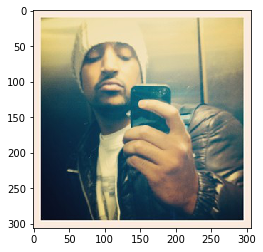

In [72]:
predict("fed5374e66d211e3ad1e12ed570e9379_6")

'average'

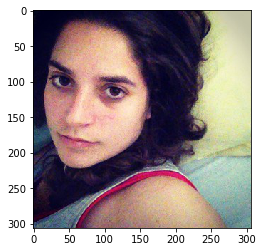

In [81]:
predict("fe40cfca3a6611e39fda22000a1f8ae8_6")

'good'

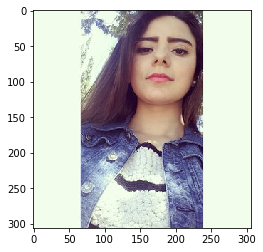

In [78]:
predict("929053_1374671502815858_704281817_a")

'average'

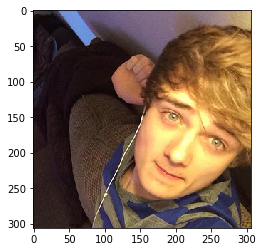

In [82]:
predict("929052_609444292479932_1680924040_a")